In [18]:
# Importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [20]:
# 1. Load and Explore Data
def load_data(filepath):
    """
    Loads the dataset and provides initial exploration.
    """
    df = pd.read_csv(filepath)
    print("Dataset Overview:\n", df.head())
    print("\nDataset Info:\n")
    print(df.info())
    print("\nMissing Values:\n", df.isnull().sum())
    return df

In [22]:
# 2. Data Visualization
def visualize_data(df):
    """
    Visualizes the dataset using histograms and bar plots.
    """
    features = ['operator', 'inout_travelling', 'network_type', 'rating', 'calldrop_category']
    for feature in features:
        plt.figure()
        plt.hist(df[feature], bins=10, alpha=0.7)
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.show()

    # Average rating by categorical features
    for feature in ['operator', 'inout_travelling', 'network_type']:
        plt.figure()
        df.groupby(feature)['rating'].mean().plot.bar()
        plt.title(f'Average Rating by {feature}')
        plt.ylabel('Average Rating')
        plt.show()

    # Pairplot for latitude and longitude with ratings
    sns.pairplot(df, hue='rating', vars=['latitude', 'longitude'])
    plt.show()

In [23]:
# 3. Data Preprocessing
def preprocess_data(df):
    """
    Handles missing values, encoding, and splits the dataset.
    """
    # Drop unnecessary columns and handle missing values
    df = df.dropna()
    X = df.drop(['rating', 'state_name', 'latitude', 'longitude'], axis=1)
    y = df['rating']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [24]:
# 4. Model Training and Evaluation
def train_models(X_train, y_train):
    """
    Trains multiple regression models and evaluates their performance.
    """
    models = [
        ('Linear Model', LinearRegression()),
        ('Lasso', Lasso()),
        ('Ridge', Ridge())
    ]
    results = []
    for name, model in models:
        kfold = KFold(n_splits=4, shuffle=True, random_state=8)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='r2', return_estimator=True)
        print(f"\nModel: {name}")
        print(f"Mean R2: {np.mean(cv_results['test_score']).round(3)} | Std Dev: {np.std(cv_results['test_score']).round(3)}")
        print('--------------------')
        results.append((name, cv_results))
    return results

In [25]:
# 5. Hyperparameter Tuning for Ridge
def grid_search_ridge(X_train, y_train):
    """
    Performs grid search for Ridge regression to find the best hyperparameters.
    """
    model = Ridge()
    params = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['auto', 'svd'],
        'tol': [0.001, 0.01, 0.1]
    }
    grid = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=4, verbose=1)
    grid.fit(X_train, y_train)
    print("\nBest Parameters:", grid.best_params_)
    return grid.best_estimator_

In [26]:
# 6. Model Evaluation
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on test data and provides metrics.
    """
    preds = model.predict(X_test)
    print("\nEvaluation Metrics:")
    print(f"R2 Score: {r2_score(y_test, preds).round(3)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, preds).round(3)}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, preds).round(3)}")

    # Predictions DataFrame
    df_pred = pd.DataFrame({'y_True': y_test.values, 'Predictions': preds.round(), 'Difference': preds.round() - y_test.values})
    print("\nSample Predictions:\n", df_pred.head(10))

    # Scatter Plot
    plt.scatter(y_test, preds, alpha=0.5)
    plt.xlabel("True Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title("True vs Predicted Ratings")
    plt.show()

Dataset Overview:
   operator inout_travelling network_type  rating   calldrop_category  \
0     BSNL           Indoor           3G       3        Satisfactory   
1     BSNL           Indoor           2G       3  Poor Voice Quality   
2     BSNL           Indoor           2G       3        Satisfactory   
3     BSNL           Indoor           3G       3        Satisfactory   
4     RJio          Outdoor           4G       4        Satisfactory   

    latitude  longitude   state_name  
0  -1.000000   -1.00000          NA   
1  -1.000000   -1.00000          NA   
2  -1.000000   -1.00000          NA   
3  -1.000000   -1.00000          NA   
4  18.519782   73.85619  Maharashtra  

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   operator           620 non-null    object 
 1   inout_travelling   620 non-null    object 
 2

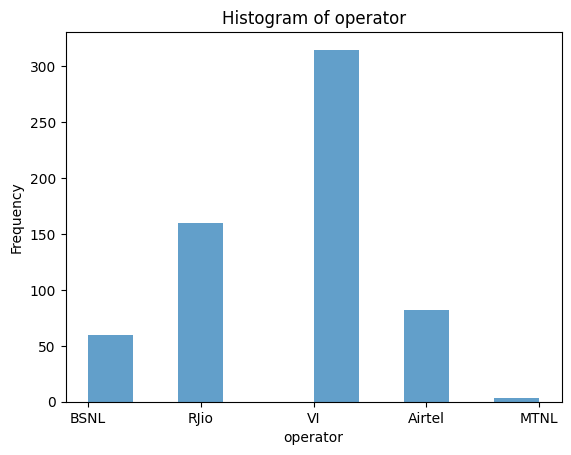

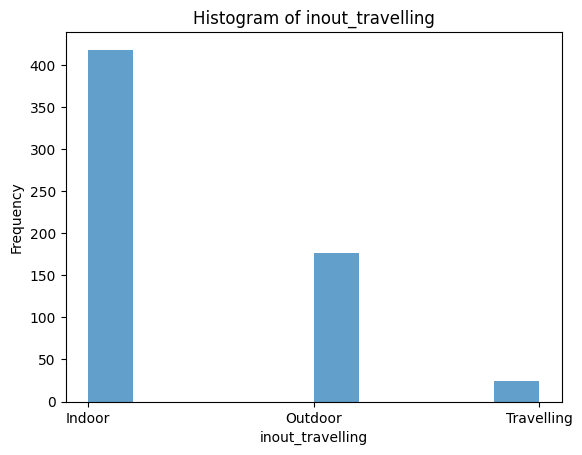

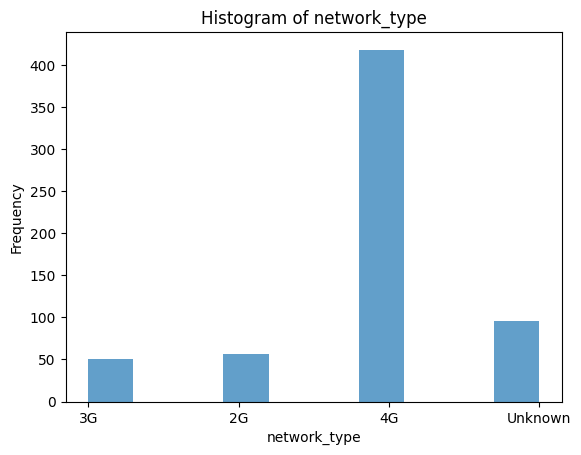

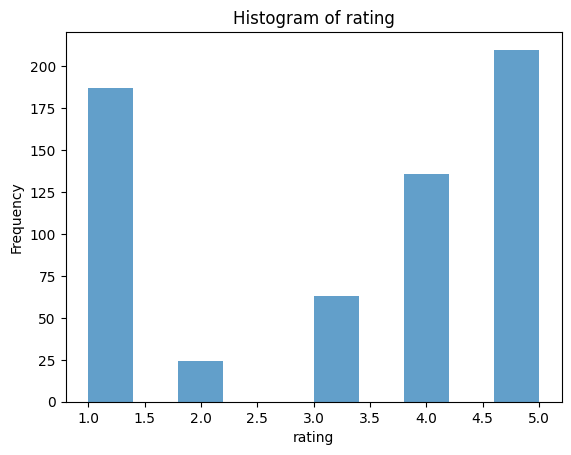

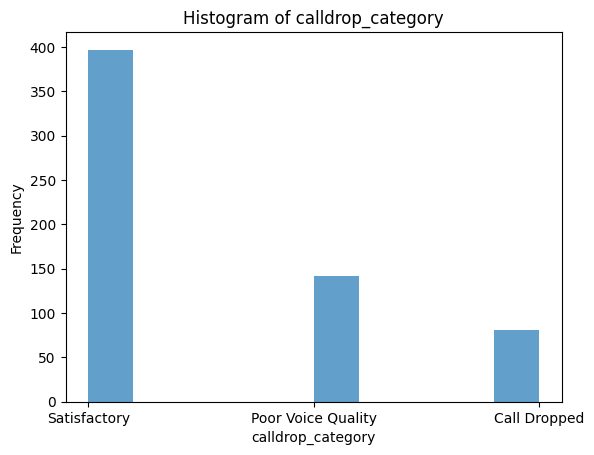

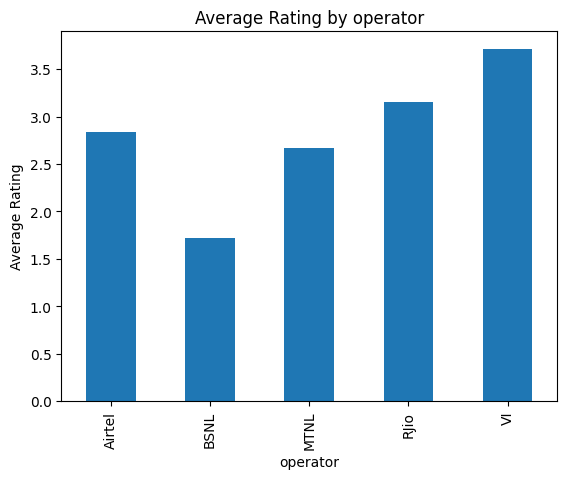

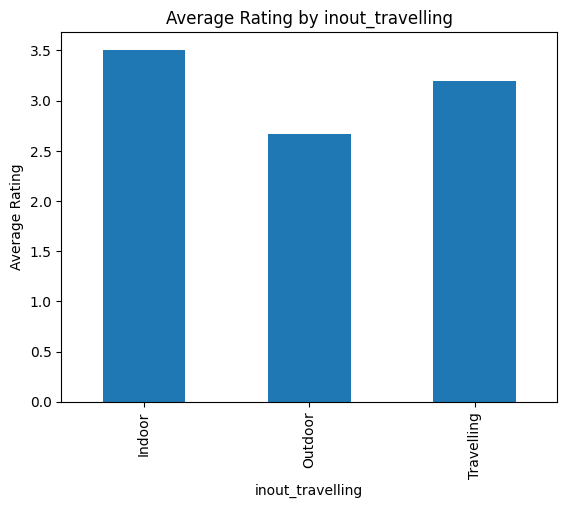

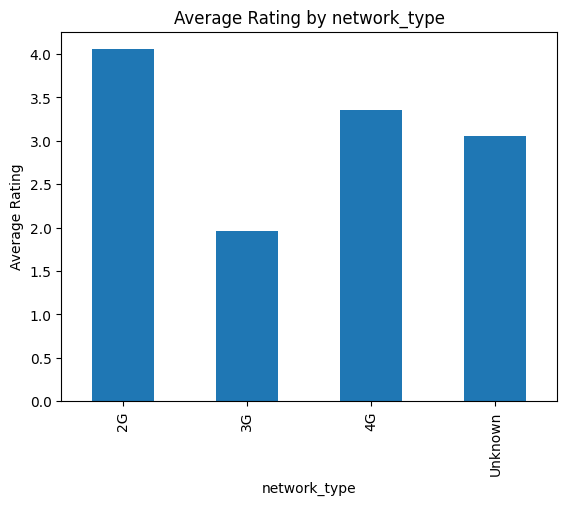

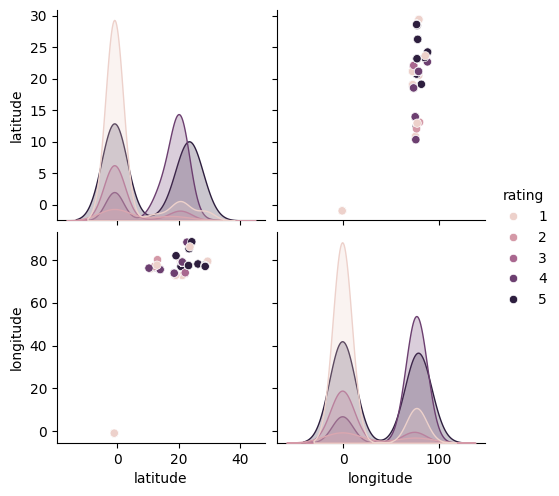

Training data: (496, 11), Testing data: (124, 11)

Model: Linear Model
Mean R2: 0.861 | Std Dev: 0.008
--------------------

Model: Lasso
Mean R2: -0.007 | Std Dev: 0.007
--------------------

Model: Ridge
Mean R2: 0.861 | Std Dev: 0.008
--------------------
Fitting 4 folds for each of 30 candidates, totalling 120 fits

Best Parameters: {'alpha': 0.1, 'solver': 'svd', 'tol': 0.001}

Evaluating the Best Model on Test Data...
Predictions (First 10): [4.48588417 4.29223781 4.46111065 4.48763138 1.4327897  4.04105332
 0.78923966 4.48763138 0.9285772  0.78923966]
True Values (First 10): [5 4 4 4 1 4 1 4 1 1]

Evaluation Metrics:
R2 Score: 0.871
Mean Absolute Error: 0.495
Mean Squared Error: 0.366

Sample Predictions:
    y_True  Predictions  Difference
0       5          4.0        -1.0
1       4          4.0         0.0
2       4          4.0         0.0
3       4          4.0         0.0
4       1          1.0         0.0
5       4          4.0         0.0
6       1          1.0         0

In [37]:
# Main Execution
filepath = '/content/January_MyCall_2022.csv'

# Load data
df = load_data(filepath)

# Visualize data
visualize_data(df)

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df)

# Train models and evaluate performance
results = train_models(X_train, y_train)

# Perform grid search for Ridge regression and get the best model
best_model = grid_search_ridge(X_train, y_train)

# Step 6: Evaluate the best model on the test set
print("\nEvaluating the Best Model on Test Data...")
evaluate_model(best_model, X_test, y_test)


def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on test data and provides metrics.
    """
    # Ensure y_test is a Pandas Series or NumPy array
    if isinstance(y_test, pd.Series):
        y_test = y_test.values  # Convert to NumPy array for consistency

    # Perform prediction
    preds = model.predict(X_test)

    # Debugging Output
    print(f"Predictions (First 10): {preds[:10]}")
    print(f"True Values (First 10): {y_test[:10]}")

    # Check if preds is a single float (in case of a single prediction)
    if np.isscalar(preds):  # If preds is a scalar (single float)
        preds = np.array([preds])  # Convert to an array

    # Evaluation Metrics
    print("\nEvaluation Metrics:")
    print(f"R2 Score: {round(r2_score(y_test, preds), 3)}")
    print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, preds), 3)}")
    print(f"Mean Squared Error: {round(mean_squared_error(y_test, preds), 3)}")

    # Predictions DataFrame
    df_pred = pd.DataFrame({
        'y_True': y_test,
        'Predictions': preds.round(),
        'Difference': preds.round() - y_test
    })
    print("\nSample Predictions:\n", df_pred.head(30))

